# Regression Analysis

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [3]:
train_data = pd.read_csv("../Data_processing/Data_Splitting/All_prefecture_Housing_training_data.csv")
dev_data = pd.read_csv("../Data_processing/Data_Splitting/All_prefecture_Housing_dev_data.csv")
cols_to_exclude = ["Type","Prefecture","Municipality"]
train_data.drop(columns=cols_to_exclude, inplace=True)
dev_data.drop(columns=cols_to_exclude, inplace=True)

#cap = np.percentile(train_data["TradePrice"], 99.9)
# Remove rows where TradePrice is less than 1e5
train_data_filtered = train_data[train_data['TradePrice'] >= 1e5]
dev_data_filtered = dev_data[dev_data['TradePrice'] >= 1e5]
#train_data_filtered = train_data_filtered[train_data_filtered['TradePrice'] <= cap]
#dev_data_filtered = dev_data_filtered[dev_data_filtered['TradePrice'] <= cap]

In [4]:
print(train_data_filtered.describe())

         TradePrice           Area       Frontage  TotalFloorArea  \
count  3.181810e+05  318181.000000  318181.000000   318181.000000   
mean   3.403163e+07     203.354867      11.441149      140.081730   
std    7.201616e+07     193.224680       6.284084      170.452118   
min    1.000000e+05      25.000000       0.700000       10.000000   
25%    1.400000e+07     110.000000       7.500000       95.000000   
50%    2.600000e+07     160.000000      10.500000      105.000000   
75%    3.700000e+07     220.000000      14.000000      125.000000   
max    1.100000e+10    2000.000000      50.000000     2000.000000   

       BuildingYear           Year        Quarter  AvgTimeToNearestStation  \
count  318181.00000  318181.000000  318181.000000            318181.000000   
mean     2000.59860    2016.378420       2.499106                25.783501   
std        17.45887       1.585752       1.095547                24.021764   
min      1945.00000    2012.000000       1.000000                 

In [5]:
train_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318181 entries, 0 to 318251
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   TradePrice                         318181 non-null  int64  
 1   Area                               318181 non-null  int64  
 2   AreaIsGreaterFlag                  318181 non-null  bool   
 3   Frontage                           318181 non-null  float64
 4   FrontageIsGreaterFlag              318181 non-null  bool   
 5   TotalFloorArea                     318181 non-null  float64
 6   TotalFloorAreaIsGreaterFlag        318181 non-null  bool   
 7   BuildingYear                       318181 non-null  float64
 8   PrewarBuilding                     318181 non-null  bool   
 9   Year                               318181 non-null  int64  
 10  Quarter                            318181 non-null  int64  
 11  AvgTimeToNearestStation            318181 no

In [6]:
def weighted_mae_log_space(y_true, y_pred):
    # Estimate original prices from log(price + 1)
    prices = tf.exp(y_true) - 1.0
    
    # Compute weights based on price
    weights = tf.square(tf.math.log(price + 2.0))  # or try tf.sqrt(prices), etc.
    
    # Standard MAE in log space
    abs_error = tf.abs(y_pred - y_true)
    
    # Weighted MAE
    return tf.reduce_mean(weights * abs_error)

In [7]:
# Log transform the target variable
#train_target_log = np.log10(train_data_filtered['TradePrice'].values)
#dev_target_log = np.log10(dev_data_filtered['TradePrice'].values)

train_target = train_data_filtered['TradePrice'].values.astype(np.float32)
dev_target = dev_data_filtered['TradePrice'].values.astype(np.float32)


#train_target = np.minimum(train_target, cap)
#dev_target = np.minimum(dev_target, cap)
train_target_log = np.log(train_target + 1)
dev_target_log = np.log(dev_target + 1)
# Extract features (without the target) as before
train_features_filtered = train_data_filtered.drop('TradePrice', axis=1).values.astype(np.float32)
dev_features_filtered = dev_data_filtered.drop('TradePrice', axis=1).values.astype(np.float32)


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_features_filtered)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(train_features_filtered.shape[1],)),
    normalizer,
    tf.keras.layers.Dense(512),  # New: increased width
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1)
])

# Define the model
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(train_features_filtered.shape[1],)),
#    normalizer,
    #tf.keras.layers.Dense(256, kernel_regularizer=regularizers.l2(0.00005), kernel_initializer='he_normal'),
#    tf.keras.layers.Dense(256),
    # Optionally add a normalization layer here (e.g., BatchNormalization or LayerNormalization) - doesn't seem to help
#    tf.keras.layers.ReLU(),
   # tf.keras.layers.Dropout(0.1),
    #tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.00005)),
#    tf.keras.layers.Dense(128),
    # Optionally add a normalization layer here - doesn't seem to help a lot
#    tf.keras.layers.ReLU(),
   # tf.keras.layers.Dropout(0.1),
#    tf.keras.layers.Dense(1)
#])

# Learning rate schedule for exponential decay.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005, 
    decay_steps=100000, #Approximately every 10 epochs
    decay_rate=0.99, 
    staircase=True
)

# Compile the model with Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='mae')

# Model summary
model.summary()






2025-04-04 22:44:37.829959: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/linuxbrew/.linuxbrew/Cellar/python@3.10/3.10.8/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 24)             │            49 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,202 (692.20 KB)

 Trainable params: 177,153 (692.00 KB)

 Non-trainable params: 49 (200.00 B)

In [8]:

class PlotPredictionsCallback(tf.keras.callbacks.Callback):
    def __init__(self, dev_features, dev_target_log, out_dir="epoch_plots"):
        super().__init__()
        self.dev_features = dev_features
        self.dev_target_log = dev_target_log
        self.out_dir = out_dir
        os.makedirs(out_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        preds_log = self.model.predict(self.dev_features).flatten()
        preds = np.exp(preds_log) - 1
        true_vals = np.exp(self.dev_target_log) - 1

        plt.figure(figsize=(6, 5))
        plt.scatter(true_vals, preds, alpha=0.3)
        plt.plot([true_vals.min(), true_vals.max()], [true_vals.min(), true_vals.max()], 'r--')
        plt.xlabel("True Price")
        plt.ylabel("Predicted Price")
        plt.title(f"True vs Predicted (Epoch {epoch+1})")
        plt.grid(True)
        plt.xscale("log")
        plt.yscale("log")
        plt.tight_layout()
        plt.savefig(f"{self.out_dir}/epoch_{epoch+1:03d}.png")
        plt.close()


In [9]:
#train_features_filtered = train_data_filtered.drop('TradePrice', axis=1).astype('float32').values
#dev_features_filtered = dev_data_filtered.drop('TradePrice', axis=1).astype('float32').values
plot_callback = PlotPredictionsCallback(dev_features_filtered, dev_target_log)
history = model.fit(
    train_features_filtered, train_target_log, 
    epochs=50, 
    batch_size=32, 
    validation_data=(dev_features_filtered, dev_target_log),
    callbacks=[plot_callback]
     )

# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']




Epoch 1/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 0.7459 - val_loss: 0.4574
Epoch 2/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.4544 - val_loss: 0.3970
Epoch 3/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 0.4266 - val_loss: 0.4108
Epoch 4/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.4223 - val_loss: 0.3931
Epoch 5/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.4058 - val_loss: 0.3990
Epoch 6/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.3994 - val_loss: 0.3926
Epoch 7/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.3966 - val_loss: 0.4616
Epoch 8/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step
9944/9

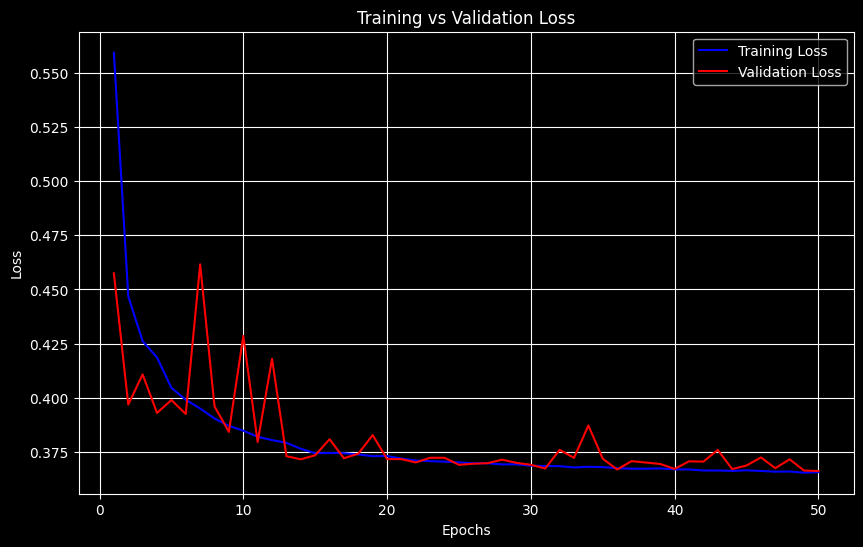

In [11]:
plt.figure(figsize=(10, 6))
plt.style.use('dark_background')
plt.plot(range(1, 51), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, 51), val_loss, label='Validation Loss', color='red')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0,100)
#plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step


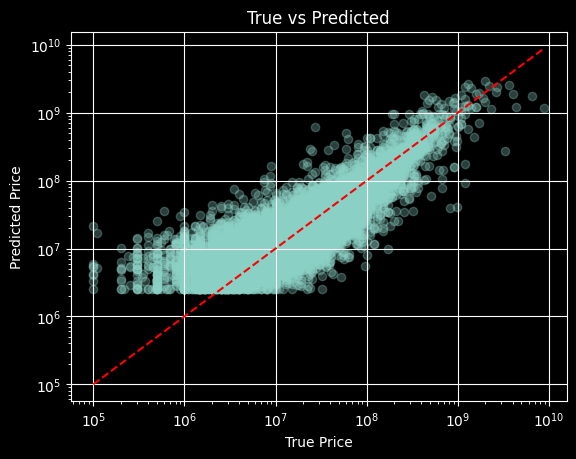

In [14]:
preds = model.predict(dev_features_filtered).flatten()
preds = np.exp(preds) - 1 
plt.style.use('dark_background')
plt.scatter(np.exp(dev_target_log) - 1, preds, alpha=0.3)
plt.plot([min(dev_target), max(dev_target)], [min(dev_target), max(dev_target)], 'r--')
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("True vs Predicted")
plt.grid(True)
#plt.xlim(0,4e9)
#plt.ylim(0,4e9)
plt.xscale("log")
plt.yscale("log")
plt.show()

1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


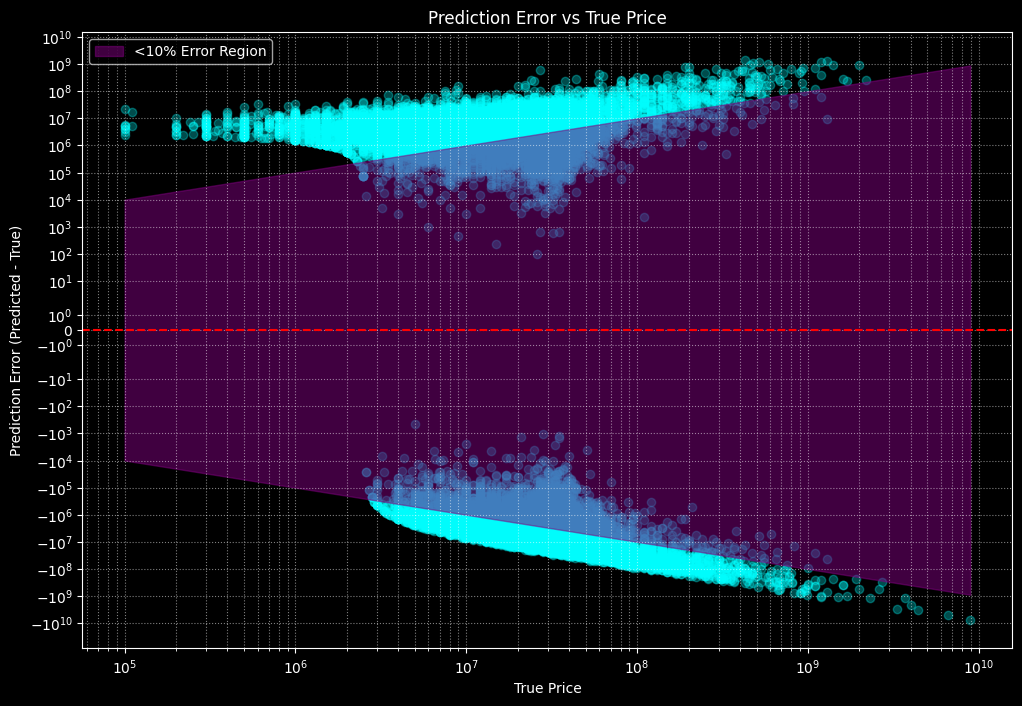

In [26]:

# Inverse transform predictions
preds = np.exp(model.predict(dev_features_filtered).flatten()) - 1

# Inverse transform the dev targets
true_prices = np.exp(dev_target_log) - 1

# Compute residuals (errors)
errors = preds - true_prices


fig, ax = plt.subplots(figsize=(12,8))

# Scatter plot of errors
ax.scatter(true_prices, errors, alpha=0.3, color='cyan')

# Reference line at zero error
ax.axhline(0, color='red', linestyle='--')

# Log scales
ax.set_xscale("log")
# Fill between -10% and +10% of the true price
x_region = np.linspace(true_prices.min(), true_prices.max(), 100)
ax.fill_between(x_region, -0.1 * x_region, 0.1 * x_region, color='purple', alpha=0.5, label='<10% Error Region')

# Labels and title
ax.set_xlabel("True Price")
ax.set_ylabel("Prediction Error (Predicted - True)")
ax.set_title("Prediction Error vs True Price")
ax.set_yscale("symlog")
# Grid and legend
ax.grid(True, which="both", linestyle=":", alpha=0.5)
ax.legend()

plt.show()



From the plot above it seems that the model consistently overestimates the price for lower true price values and is slightly prone to underestimating the price for very high true price values.
